In [12]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import vpfits

In [13]:
# cont = pd.read_table('q1422.cont', delim_whitespace=True, header=None)
# cont.columns = ['wavelength', 'velocity', 'flux', 'noise']
# cont.head()

In [14]:
cont = np.loadtxt('q1422.cont')

In [15]:
vpfit = vpfits.VPfit()

In [16]:
buffer = 3
min_region_width = 5

regions = vpfit.compute_detection_regions(cont[:,0], cont[:,2], cont[:,3], 
                                          buffer=buffer, min_region_width=min_region_width)

#regions = vpfit.compute_detection_regions(cont['wavelength'], cont['flux'], cont['noise'], 
#                                          buffer=buffer, min_region_width=min_region_width)

#print(regions)

In [17]:
# region_arrays = []
# region_pixels = []
# for region in regions:
#     start = np.where(cont['wavelength'] == region[0])[0][0]
#     end = np.where(cont['wavelength'] == region[1])[0][0]
#     region_pixels.append([start, end])
#     region_arrays.append([cont['wavelength'][start:end], cont['flux'][start:end]])

In [18]:
region_arrays = []
region_pixels = []
for region in regions:
    start = np.where(cont[:,0] == region[0])[0][0]
    end = np.where(cont[:,0] == region[1])[0][0]
    region_pixels.append([start, end])
    region_arrays.append([cont[:,0][start:end], cont[:,2][start:end]])

In [19]:
def plot_bracket(x, axis, dir):
    height = .2
    arm_length = 0.2
    axis.plot((x, x), (1-height/2, 1+height/2), color='magenta')

    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length

    axis.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    axis.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')


In [20]:
# N = 6

# fig, ax = plt.subplots(N, figsize=(10,10))

# for n in range(N):
    
#     length = len(cont) / N
    
#     lower_lim = n*length
#     upper_lim = n*length+length
    
#     ax[n].plot(cont['wavelength'], cont['flux'], c='black')
    
#     ax[n].set_xlim(cont['wavelength'][lower_lim], cont['wavelength'][upper_lim])

#     for arr in region_arrays:
#         ax[n].plot(arr[0], arr[1], color='blue')

#     for (start, end) in region_pixels:
#         plot_bracket(cont['wavelength'][start], ax[n], 'left')
#         plot_bracket(cont['wavelength'][end], ax[n], 'right')


# plt.show()

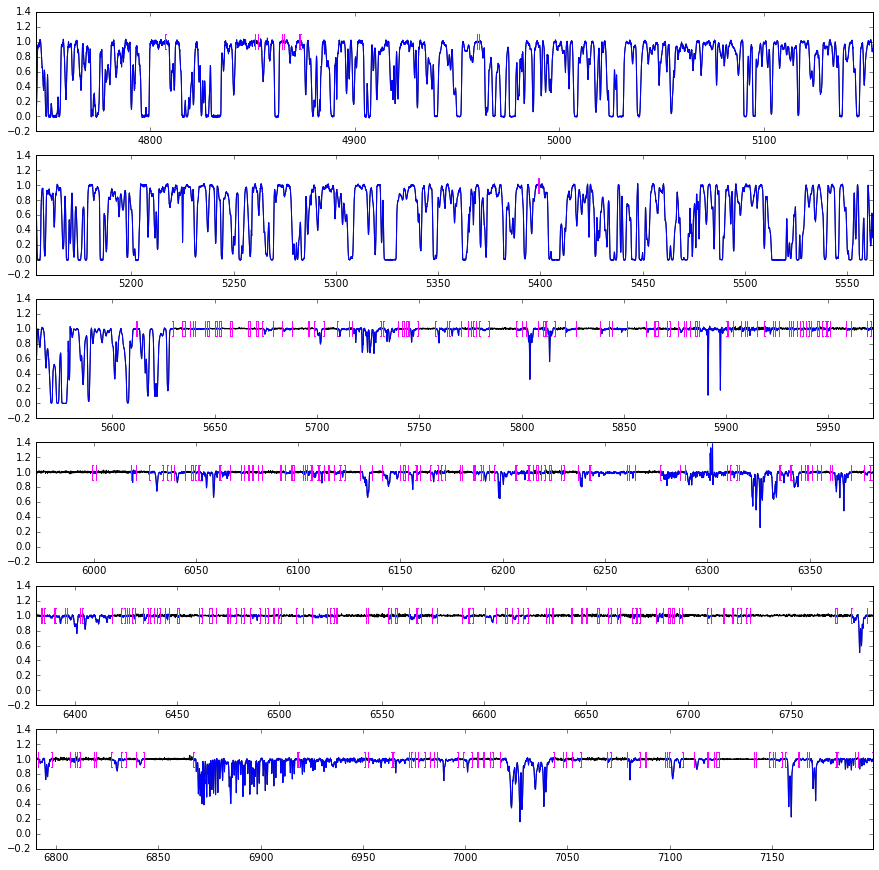

In [21]:
N = 6

fig, ax = plt.subplots(N, figsize=(15,15))

for n in range(N):
    
    length = len(cont) / N
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(cont[:,0], cont[:,2], c='black')
    
    ax[n].set_xlim(cont[:,0][lower_lim], cont[:,0][upper_lim])

    for arr in region_arrays:
        ax[n].plot(arr[0], arr[1], color='blue')

    for (start, end) in region_pixels:
        plot_bracket(cont[:,0][start], ax[n], 'left')
        plot_bracket(cont[:,0][end], ax[n], 'right')


plt.show()

## Fit

n:  2
Fit 1 BIC:  1585.3234989 , Fit 2 BIC:  1196.39831188
BIC Ratio:  1.32508001989
n (final):  1
 [-----------------100%-----------------] 10000 of 10000 complete in 3.7 sec
Took: 0:00:03.669891  to finish.


/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


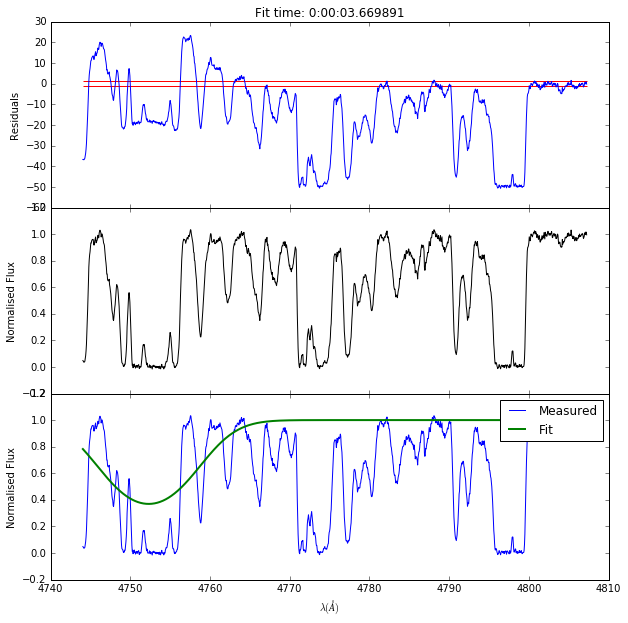

n:  2
Fit 1 BIC:  792.327895168 , Fit 2 BIC:  239.405584714
BIC Ratio:  3.30956312534
n (final):  1
 [-----------------100%-----------------] 10000 of 10000 complete in 3.6 sec
Took: 0:00:03.614193  to finish.


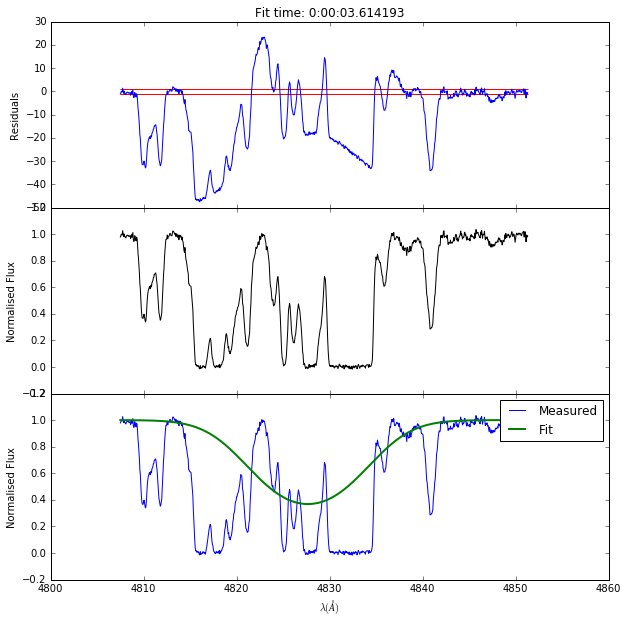

n:  2
Fit 1 BIC:  20.7737842664 , Fit 2 BIC:  -7.00533492335
BIC Ratio:  -2.96542342282
n:  3
Fit 1 BIC:  -7.00533492335 , Fit 2 BIC:  -239.778328899
BIC Ratio:  0.0292158801653
n:  4
Fit 1 BIC:  -239.778328899 , Fit 2 BIC:  -223.454642658
BIC Ratio:  1.07305145262
n (final):  3
 [-----------------100%-----------------] 10000 of 10000 complete in 5.5 sec
Took: 0:00:05.516639  to finish.


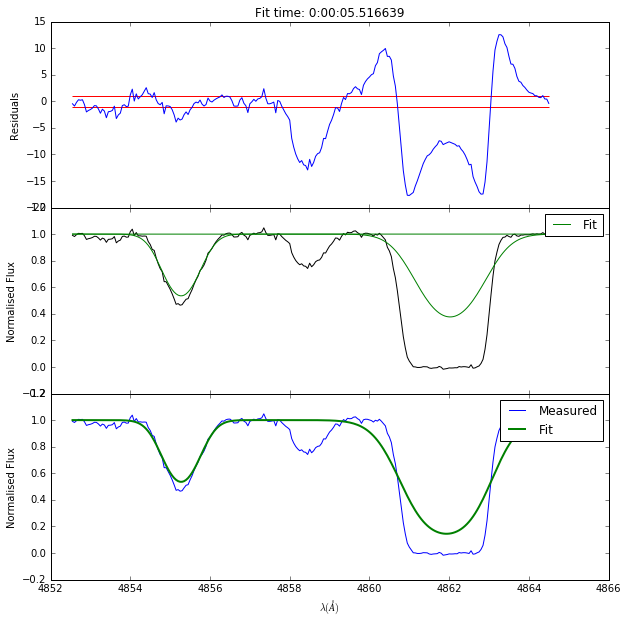

n:  2
Fit 1 BIC:  -450.749791738 , Fit 2 BIC:  -435.94301361
BIC Ratio:  1.0339649396
n (final):  1
 [-----------------100%-----------------] 10000 of 10000 complete in 2.4 sec
Took: 0:00:02.446688  to finish.


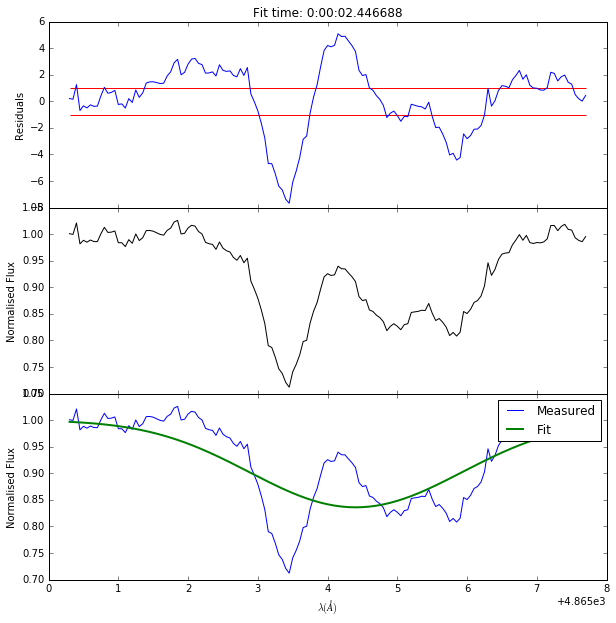

n:  2
Fit 1 BIC:  2026.88293475 , Fit 2 BIC:  2066.1216638
BIC Ratio:  0.981008509935
n (final):  1
 [-----------------100%-----------------] 10000 of 10000 complete in 4.9 sec
Took: 0:00:04.920301  to finish.


KeyboardInterrupt: 

In [22]:
fits = []

for i in range(len(region_arrays)):
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    r = 0
    n = 1
    
    vpfit_2 = vpfits.VPfit()
    vpfit_2.initialise_model(wavelengths, fluxes, n)
    vpfit_2.map_estimate()

    while r < 0.95:

        n += 1
        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        vpfit_2.initialise_model(wavelengths, fluxes, n)
        vpfit_2.map_estimate()
        
        print "Fit 1 BIC: ", vpfit_1.MAP.BIC, ", Fit 2 BIC: ", vpfit_2.MAP.BIC
        print "BIC Ratio: ", vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
        
        r = vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
    
    n -= 1
    print "n (final): ", n
    vpfit_1.mcmc_fit()
    
    fits.append(vpfit_1)
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    vpfit_1.plot(wavelengths, fluxes, n=n, start_pix=start, end_pix=end)